# Imports

In [1]:
import pickle
import torch
import random
import math
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.transforms import v2
from google.colab import drive
from google.colab import runtime
from PIL import Image
!pip install torchinfo
!pip install tensorboard
from torchinfo import summary
drive.mount('/content/drive')

Mounted at /content/drive


# Data

File Loading

In [2]:
# Load training data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

# Load validation data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

In [3]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

Data Transformations

In [15]:
class RandomHorizontalFlipWithSteeringAngle(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            v2.functional.hflip(input)
            output[0] = -output[0]
        return input, output

class TrainDataAugmentation(nn.Module):
    def __init__(self):
        super(TrainDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((119//2, 256//2)),
            v2.ToPILImage(),
            # v2.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            # v2.RandomRotation(degrees=45),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

class ValDataAugmentation(nn.Module):
    def __init__(self):
        super(ValDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((119//2, 256//2)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

Data Preprocessing

In [16]:
class AVDataset(Dataset):
    def __init__(self, input_images, output_values, transform):
        self.input_images = input_images
        self.output_values = output_values
        self.transform = transform

    def __len__(self):
        return len(self.output_values)

    def __getitem__(self, idx):
        input_image = self.input_images[idx]
        output_value = self.output_values[idx]

        if self.transform:
            input_image = self.transform(input_image)
            # input_image, output_value = RandomHorizontalFlipWithSteeringAngle(0.5)(input_image, output_value)

        return input_image, output_value

train_data_augmentation = TrainDataAugmentation()
val_data_augmentation = ValDataAugmentation()

train_dataset = AVDataset(input_images=train_data, output_values=train_labels, transform=train_data_augmentation)
val_dataset = AVDataset(input_images=val_data, output_values=val_labels, transform=val_data_augmentation)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)

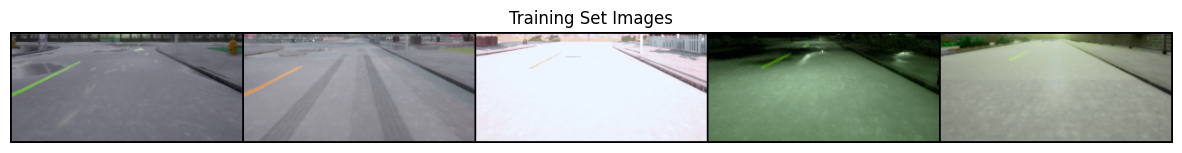

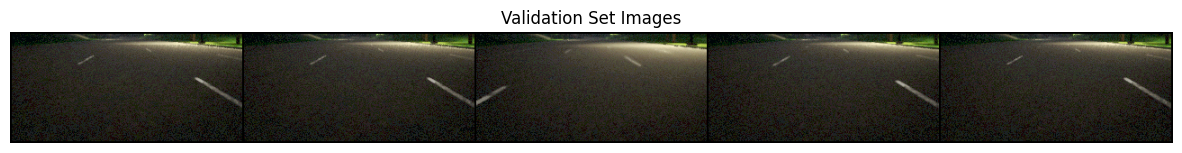

In [17]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    # Get a batch of images
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    # Select 5 random indices
    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    # Call the helper function to show images
    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(train_loader, title="Training Set Images")
plot_images_from_loader(val_loader, title="Validation Set Images")

# Model

Neural Network

In [7]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

In [8]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

In [9]:
class AVModel(nn.Module):
    def __init__(self):
        super(AVModel, self).__init__()
        self.conv1 = SeparableConv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = nn.LayerNorm(64)
        self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=1, dropout=0.5, batch_first=True)
        self.scale = nn.Parameter(torch.zeros(1))
        self.act = nn.SELU()

        self.conv_layers = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=4, pool=True, short=True),
            ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=4, pool=True, short=True),
            ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=4, pool=True, short=True),
            nn.Dropout2d(0.5),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(256, 100, bias=False),
            nn.SELU(),
            nn.Linear(100, 50, bias=False),
            nn.SELU(),
            nn.Linear(50, 10, bias=False),
            nn.SELU(),
            nn.Dropout(0.5),
        )

        self.output_layer = nn.Linear(10, 3)

    def forward(self, x):
        x = self.conv1(x)
        # batch_size, channels, height, width = x.size()
        # x_att = x.reshape(batch_size, channels, height * width).transpose(1, 2)
        # x_att = self.norm(x_att)
        # attention_output, _ = self.attention(x_att, x_att, x_att)
        # attention_output = attention_output.transpose(1, 2).reshape(batch_size, channels, height, width)
        # x = self.scale * attention_output + x
        x = self.act(x)

        x = self.conv_layers(x)
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) # GlobalAveragePooling2D
        x = self.dense_layers(x)
        x = self.output_layer(x)
        out = torch.sigmoid(x)

        # Bounding the output
        # steering_output = F.hardtanh(x[:, 0:1])
        # throttle_brake_output = F.hardtanh(x[:, 1:], min_val=0)
        # out = torch.cat((steering_output, throttle_brake_output), dim=1)
        return out

# Util

MFPE Loss

In [10]:
class MFPELoss(nn.Module):
    def __init__(self):
        super(MFPELoss, self).__init__()

    def forward(self, input, target):
        error = input - target
        fourth_power_error = error ** 4
        mean_fourth_power_error = torch.mean(fourth_power_error)
        return mean_fourth_power_error

Early Stopping

In [11]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Autoclip

In [12]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [13]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, f'/content/drive/My Drive/AV Research/Checkpoints/new_model_checkpoint_{epoch}.pt')

# Training Loop

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AVModel().to(device)
num_epochs = 50
learning_rate = 1e-4
criterion = MFPELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=(num_epochs // 5))
early_stopping = EarlyStopping(patience=7)

torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()
autoclipper = AutoClip(percentile=10)

writer = SummaryWriter()

train_losses = []
val_losses = []

print(summary(model, input_size=(batch_size, 3, 119 // 2, 256 // 2)))

def train_loop(train_loader, model, criterion, optimizer, device):
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets)

        train_loss += loss.item()
        scaler.scale(loss).backward()
        autoclipper(model)

        scaler.step(optimizer)
        scale = scaler.get_scale()
        scaler.update()
        skip_lr_sched = (scale != scaler.get_scale())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(inputs)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = train_loss / num_batches
    return train_loss, skip_lr_sched

def val_loop(val_loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss = val_loss / num_batches
    return val_loss

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, skip_lr_sched = train_loop(train_loader, model, criterion, optimizer, device)
    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch+1)
    writer.add_scalar('Loss/val', val_loss, epoch+1)

    save_checkpoint(model, optimizer, scheduler, epoch+1, train_losses, val_losses)

    # if early_stopping.early_stop(val_loss):
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    print("Last learning rate:", scheduler.get_last_lr())
    if not skip_lr_sched:
        scheduler.step()

writer.close()

Layer (type:depth-idx)                        Output Shape              Param #
AVModel                                       [128, 3]                  16,769
├─SeparableConv2d: 1-1                        [128, 64, 59, 128]        --
│    └─Conv2d: 2-1                            [128, 3, 59, 128]         27
│    └─Conv2d: 2-2                            [128, 64, 59, 128]        192
├─SELU: 1-2                                   [128, 64, 59, 128]        --
├─Sequential: 1-3                             [128, 256, 8, 16]         --
│    └─ResidualBlock: 2-3                     [128, 64, 30, 64]         --
│    │    └─Sequential: 3-1                   [128, 64, 59, 128]        4,672
│    │    └─Sequential: 3-2                   [128, 64, 59, 128]        14,016
│    │    └─MaxPool2d: 3-3                    [128, 64, 30, 64]         --
│    │    └─Conv2d: 3-4                       [128, 64, 30, 64]         4,096
│    │    └─SELU: 3-5                         [128, 64, 30, 64]         --
│    

  0%|          | 0/1088 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 1/1088 [00:01<22:27,  1.24s/it]

Training loss: 0.062934  [  128/139199]


  9%|▉         | 101/1088 [01:04<10:21,  1.59it/s]

Training loss: 0.036812  [12928/139199]


 18%|█▊        | 201/1088 [02:07<09:27,  1.56it/s]

Training loss: 0.035457  [25728/139199]


 28%|██▊       | 301/1088 [03:10<08:13,  1.59it/s]

Training loss: 0.031893  [38528/139199]


 37%|███▋      | 401/1088 [04:13<07:10,  1.60it/s]

Training loss: 0.033049  [51328/139199]


 46%|████▌     | 501/1088 [05:15<06:02,  1.62it/s]

Training loss: 0.034318  [64128/139199]


 55%|█████▌    | 601/1088 [06:17<04:57,  1.64it/s]

Training loss: 0.032787  [76928/139199]


 64%|██████▍   | 701/1088 [07:19<03:57,  1.63it/s]

Training loss: 0.032175  [89728/139199]


 74%|███████▎  | 801/1088 [08:21<03:00,  1.59it/s]

Training loss: 0.031277  [102528/139199]


 83%|████████▎ | 901/1088 [09:23<01:55,  1.62it/s]

Training loss: 0.030755  [115328/139199]


 92%|█████████▏| 1001/1088 [10:25<00:53,  1.64it/s]

Training loss: 0.030577  [128128/139199]


100%|██████████| 1088/1088 [11:19<00:00,  1.60it/s]


Train loss: 0.032936 - Val loss: 0.022139 

Last learning rate: [0.0001]
Epoch 2
-------------------------------


  0%|          | 1/1088 [00:01<22:26,  1.24s/it]

Training loss: 0.028466  [  128/139199]


  9%|▉         | 101/1088 [01:04<10:22,  1.58it/s]

Training loss: 0.027866  [12928/139199]


 18%|█▊        | 201/1088 [02:06<09:05,  1.63it/s]

Training loss: 0.027134  [25728/139199]


 28%|██▊       | 301/1088 [03:08<08:15,  1.59it/s]

Training loss: 0.028954  [38528/139199]


 37%|███▋      | 401/1088 [04:11<07:07,  1.61it/s]

Training loss: 0.027307  [51328/139199]


 46%|████▌     | 501/1088 [05:13<06:05,  1.61it/s]

Training loss: 0.025542  [64128/139199]


 55%|█████▌    | 601/1088 [06:15<05:00,  1.62it/s]

Training loss: 0.029786  [76928/139199]


 64%|██████▍   | 701/1088 [07:17<04:00,  1.61it/s]

Training loss: 0.028443  [89728/139199]


 74%|███████▎  | 801/1088 [08:19<02:59,  1.60it/s]

Training loss: 0.027688  [102528/139199]


 83%|████████▎ | 901/1088 [09:22<01:58,  1.57it/s]

Training loss: 0.027269  [115328/139199]


 92%|█████████▏| 1001/1088 [10:25<00:54,  1.59it/s]

Training loss: 0.028156  [128128/139199]


100%|██████████| 1088/1088 [11:20<00:00,  1.60it/s]


Train loss: 0.028228 - Val loss: 0.021948 

Last learning rate: [9.755282581475769e-05]
Epoch 3
-------------------------------


  0%|          | 1/1088 [00:01<22:46,  1.26s/it]

Training loss: 0.026637  [  128/139199]


  9%|▉         | 101/1088 [01:05<10:25,  1.58it/s]

Training loss: 0.028058  [12928/139199]


 18%|█▊        | 201/1088 [02:08<09:30,  1.56it/s]

Training loss: 0.029346  [25728/139199]


 28%|██▊       | 301/1088 [03:12<08:24,  1.56it/s]

Training loss: 0.026421  [38528/139199]


 37%|███▋      | 401/1088 [04:15<07:15,  1.58it/s]

Training loss: 0.027123  [51328/139199]


 46%|████▌     | 501/1088 [05:19<06:12,  1.57it/s]

Training loss: 0.026188  [64128/139199]


 55%|█████▌    | 601/1088 [06:23<05:03,  1.60it/s]

Training loss: 0.027766  [76928/139199]


 64%|██████▍   | 701/1088 [07:26<04:12,  1.54it/s]

Training loss: 0.024522  [89728/139199]


 74%|███████▎  | 801/1088 [08:29<02:59,  1.60it/s]

Training loss: 0.023148  [102528/139199]


 83%|████████▎ | 901/1088 [09:33<01:57,  1.59it/s]

Training loss: 0.025637  [115328/139199]


 92%|█████████▏| 1001/1088 [10:37<00:56,  1.54it/s]

Training loss: 0.024227  [128128/139199]


100%|██████████| 1088/1088 [11:31<00:00,  1.57it/s]


Train loss: 0.026037 - Val loss: 0.019654 

Last learning rate: [9.045084971874738e-05]
Epoch 4
-------------------------------


  0%|          | 1/1088 [00:01<22:26,  1.24s/it]

Training loss: 0.022711  [  128/139199]


  9%|▉         | 101/1088 [01:04<10:22,  1.58it/s]

Training loss: 0.024008  [12928/139199]


 18%|█▊        | 201/1088 [02:07<09:27,  1.56it/s]

Training loss: 0.024276  [25728/139199]


 28%|██▊       | 301/1088 [03:10<08:20,  1.57it/s]

Training loss: 0.023899  [38528/139199]


 37%|███▋      | 401/1088 [04:13<07:24,  1.55it/s]

Training loss: 0.023633  [51328/139199]


 46%|████▌     | 501/1088 [05:15<06:11,  1.58it/s]

Training loss: 0.023936  [64128/139199]


 55%|█████▌    | 601/1088 [06:19<05:18,  1.53it/s]

Training loss: 0.021228  [76928/139199]


 64%|██████▍   | 701/1088 [07:22<04:09,  1.55it/s]

Training loss: 0.022406  [89728/139199]


 74%|███████▎  | 801/1088 [08:25<03:04,  1.55it/s]

Training loss: 0.017545  [102528/139199]


 83%|████████▎ | 901/1088 [09:28<01:56,  1.60it/s]

Training loss: 0.019718  [115328/139199]


 92%|█████████▏| 1001/1088 [10:31<00:54,  1.60it/s]

Training loss: 0.021167  [128128/139199]


100%|██████████| 1088/1088 [11:26<00:00,  1.59it/s]


Train loss: 0.021609 - Val loss: 0.016060 

Last learning rate: [7.938926261462366e-05]
Epoch 5
-------------------------------


  0%|          | 1/1088 [00:01<28:58,  1.60s/it]

Training loss: 0.017700  [  128/139199]


  9%|▉         | 101/1088 [01:04<10:21,  1.59it/s]

Training loss: 0.018676  [12928/139199]


 18%|█▊        | 201/1088 [02:07<09:16,  1.59it/s]

Training loss: 0.019843  [25728/139199]


 28%|██▊       | 301/1088 [03:10<08:21,  1.57it/s]

Training loss: 0.014104  [38528/139199]


 37%|███▋      | 401/1088 [04:14<07:16,  1.57it/s]

Training loss: 0.022082  [51328/139199]


 46%|████▌     | 501/1088 [05:16<06:16,  1.56it/s]

Training loss: 0.018633  [64128/139199]


 55%|█████▌    | 601/1088 [06:18<05:00,  1.62it/s]

Training loss: 0.016209  [76928/139199]


 64%|██████▍   | 701/1088 [07:21<03:59,  1.61it/s]

Training loss: 0.017105  [89728/139199]


 74%|███████▎  | 801/1088 [08:24<03:00,  1.59it/s]

Training loss: 0.019176  [102528/139199]


 83%|████████▎ | 901/1088 [09:27<01:58,  1.58it/s]

Training loss: 0.025621  [115328/139199]


 92%|█████████▏| 1001/1088 [10:30<00:54,  1.60it/s]

Training loss: 0.021307  [128128/139199]


100%|██████████| 1088/1088 [11:24<00:00,  1.59it/s]


Train loss: 0.018257 - Val loss: 0.016064 

Last learning rate: [6.545084971874738e-05]
Epoch 6
-------------------------------


  0%|          | 1/1088 [00:01<22:55,  1.27s/it]

Training loss: 0.021228  [  128/139199]


  9%|▉         | 101/1088 [01:03<10:16,  1.60it/s]

Training loss: 0.020109  [12928/139199]


 18%|█▊        | 201/1088 [02:06<09:10,  1.61it/s]

Training loss: 0.014973  [25728/139199]


 28%|██▊       | 301/1088 [03:09<08:11,  1.60it/s]

Training loss: 0.018151  [38528/139199]


 37%|███▋      | 401/1088 [04:11<07:01,  1.63it/s]

Training loss: 0.016486  [51328/139199]


 46%|████▌     | 501/1088 [05:13<06:00,  1.63it/s]

Training loss: 0.016186  [64128/139199]


 55%|█████▌    | 601/1088 [06:15<05:04,  1.60it/s]

Training loss: 0.014472  [76928/139199]


 64%|██████▍   | 701/1088 [07:17<04:01,  1.60it/s]

Training loss: 0.014832  [89728/139199]


 74%|███████▎  | 801/1088 [08:20<02:59,  1.60it/s]

Training loss: 0.017312  [102528/139199]


 83%|████████▎ | 901/1088 [09:23<01:58,  1.58it/s]

Training loss: 0.014491  [115328/139199]


 92%|█████████▏| 1001/1088 [10:27<00:54,  1.60it/s]

Training loss: 0.014294  [128128/139199]


100%|██████████| 1088/1088 [11:21<00:00,  1.60it/s]


Train loss: 0.016727 - Val loss: 0.013406 

Last learning rate: [5e-05]
Epoch 7
-------------------------------


  0%|          | 1/1088 [00:01<22:26,  1.24s/it]

Training loss: 0.018242  [  128/139199]


  9%|▉         | 101/1088 [01:03<10:19,  1.59it/s]

Training loss: 0.012608  [12928/139199]


 18%|█▊        | 201/1088 [02:06<09:02,  1.63it/s]

Training loss: 0.017361  [25728/139199]


 28%|██▊       | 301/1088 [03:08<08:09,  1.61it/s]

Training loss: 0.013236  [38528/139199]


 37%|███▋      | 401/1088 [04:11<07:03,  1.62it/s]

Training loss: 0.015493  [51328/139199]


 46%|████▌     | 501/1088 [05:13<05:54,  1.65it/s]

Training loss: 0.013774  [64128/139199]


 55%|█████▌    | 601/1088 [06:16<04:58,  1.63it/s]

Training loss: 0.014522  [76928/139199]


 64%|██████▍   | 701/1088 [07:19<04:08,  1.55it/s]

Training loss: 0.016559  [89728/139199]


 74%|███████▎  | 801/1088 [08:23<03:00,  1.59it/s]

Training loss: 0.017072  [102528/139199]


 83%|████████▎ | 901/1088 [09:26<01:59,  1.56it/s]

Training loss: 0.018151  [115328/139199]


 92%|█████████▏| 1001/1088 [10:30<00:55,  1.56it/s]

Training loss: 0.015549  [128128/139199]


100%|██████████| 1088/1088 [11:25<00:00,  1.59it/s]


Train loss: 0.016141 - Val loss: 0.013387 

Last learning rate: [3.4549150281252636e-05]
Epoch 8
-------------------------------


  0%|          | 1/1088 [00:01<22:43,  1.25s/it]

Training loss: 0.020386  [  128/139199]


  9%|▉         | 101/1088 [01:03<10:15,  1.60it/s]

Training loss: 0.017155  [12928/139199]


 18%|█▊        | 201/1088 [02:05<09:18,  1.59it/s]

Training loss: 0.020046  [25728/139199]


 28%|██▊       | 301/1088 [03:09<08:08,  1.61it/s]

Training loss: 0.015673  [38528/139199]


 37%|███▋      | 401/1088 [04:12<07:11,  1.59it/s]

Training loss: 0.011881  [51328/139199]


 46%|████▌     | 501/1088 [05:14<06:06,  1.60it/s]

Training loss: 0.020291  [64128/139199]


 55%|█████▌    | 601/1088 [06:17<05:02,  1.61it/s]

Training loss: 0.018531  [76928/139199]


 64%|██████▍   | 701/1088 [07:20<04:03,  1.59it/s]

Training loss: 0.017780  [89728/139199]


 74%|███████▎  | 801/1088 [08:24<02:55,  1.63it/s]

Training loss: 0.018947  [102528/139199]


 83%|████████▎ | 901/1088 [09:26<01:59,  1.56it/s]

Training loss: 0.013943  [115328/139199]


 92%|█████████▏| 1001/1088 [10:30<00:53,  1.61it/s]

Training loss: 0.015350  [128128/139199]


100%|██████████| 1088/1088 [11:24<00:00,  1.59it/s]


Train loss: 0.015793 - Val loss: 0.012828 

Last learning rate: [2.061073738537635e-05]
Epoch 9
-------------------------------


  0%|          | 1/1088 [00:01<22:49,  1.26s/it]

Training loss: 0.013391  [  128/139199]


  9%|▉         | 101/1088 [01:03<10:03,  1.64it/s]

Training loss: 0.015189  [12928/139199]


 18%|█▊        | 201/1088 [02:05<09:09,  1.61it/s]

Training loss: 0.013508  [25728/139199]


 28%|██▊       | 301/1088 [03:07<08:08,  1.61it/s]

Training loss: 0.014372  [38528/139199]


 37%|███▋      | 401/1088 [04:09<07:03,  1.62it/s]

Training loss: 0.015547  [51328/139199]


 46%|████▌     | 501/1088 [05:11<06:10,  1.58it/s]

Training loss: 0.013216  [64128/139199]


 55%|█████▌    | 601/1088 [06:13<05:04,  1.60it/s]

Training loss: 0.014620  [76928/139199]


 64%|██████▍   | 701/1088 [07:15<03:58,  1.62it/s]

Training loss: 0.016662  [89728/139199]


 74%|███████▎  | 801/1088 [08:17<02:55,  1.64it/s]

Training loss: 0.016277  [102528/139199]


 83%|████████▎ | 901/1088 [09:20<01:56,  1.60it/s]

Training loss: 0.013968  [115328/139199]


 92%|█████████▏| 1001/1088 [10:22<00:55,  1.56it/s]

Training loss: 0.015922  [128128/139199]


100%|██████████| 1088/1088 [11:16<00:00,  1.61it/s]


Train loss: 0.015677 - Val loss: 0.012847 

Last learning rate: [9.549150281252633e-06]
Epoch 10
-------------------------------


  0%|          | 1/1088 [00:01<22:39,  1.25s/it]

Training loss: 0.013493  [  128/139199]


  9%|▉         | 101/1088 [01:03<10:23,  1.58it/s]

Training loss: 0.015342  [12928/139199]


 18%|█▊        | 201/1088 [02:06<09:08,  1.62it/s]

Training loss: 0.017374  [25728/139199]


 28%|██▊       | 301/1088 [03:08<08:21,  1.57it/s]

Training loss: 0.017342  [38528/139199]


 37%|███▋      | 401/1088 [04:10<07:05,  1.61it/s]

Training loss: 0.015687  [51328/139199]


 46%|████▌     | 501/1088 [05:13<06:12,  1.58it/s]

Training loss: 0.015659  [64128/139199]


 55%|█████▌    | 601/1088 [06:15<05:06,  1.59it/s]

Training loss: 0.017575  [76928/139199]


 64%|██████▍   | 701/1088 [07:19<04:04,  1.58it/s]

Training loss: 0.015721  [89728/139199]


 74%|███████▎  | 801/1088 [08:22<03:03,  1.57it/s]

Training loss: 0.014388  [102528/139199]


 83%|████████▎ | 901/1088 [09:26<01:59,  1.56it/s]

Training loss: 0.016668  [115328/139199]


 92%|█████████▏| 1001/1088 [10:29<00:54,  1.60it/s]

Training loss: 0.014108  [128128/139199]


100%|██████████| 1088/1088 [11:23<00:00,  1.59it/s]


Train loss: 0.015534 - Val loss: 0.012862 

Last learning rate: [2.4471741852423237e-06]
Epoch 11
-------------------------------


  0%|          | 1/1088 [00:01<23:42,  1.31s/it]

Training loss: 0.018393  [  128/139199]


  9%|▉         | 101/1088 [01:03<10:11,  1.61it/s]

Training loss: 0.011904  [12928/139199]


 18%|█▊        | 201/1088 [02:06<09:12,  1.61it/s]

Training loss: 0.015982  [25728/139199]


 28%|██▊       | 301/1088 [03:08<08:13,  1.59it/s]

Training loss: 0.016554  [38528/139199]


 37%|███▋      | 401/1088 [04:11<07:15,  1.58it/s]

Training loss: 0.013747  [51328/139199]


 46%|████▌     | 501/1088 [05:13<06:10,  1.58it/s]

Training loss: 0.012289  [64128/139199]


 55%|█████▌    | 601/1088 [06:17<05:00,  1.62it/s]

Training loss: 0.016390  [76928/139199]


 64%|██████▍   | 701/1088 [07:20<04:02,  1.60it/s]

Training loss: 0.019273  [89728/139199]


 74%|███████▎  | 801/1088 [08:24<03:07,  1.53it/s]

Training loss: 0.014340  [102528/139199]


 83%|████████▎ | 901/1088 [09:27<01:56,  1.60it/s]

Training loss: 0.017815  [115328/139199]


 92%|█████████▏| 1001/1088 [10:29<00:54,  1.60it/s]

Training loss: 0.014623  [128128/139199]


100%|██████████| 1088/1088 [11:24<00:00,  1.59it/s]


Train loss: 0.015665 - Val loss: 0.012958 

Last learning rate: [0.0001]
Epoch 12
-------------------------------


  0%|          | 1/1088 [00:01<22:25,  1.24s/it]

Training loss: 0.016691  [  128/139199]


  9%|▉         | 101/1088 [01:02<10:13,  1.61it/s]

Training loss: 0.022825  [12928/139199]


 18%|█▊        | 201/1088 [02:04<09:08,  1.62it/s]

Training loss: 0.024780  [25728/139199]


 28%|██▊       | 301/1088 [03:05<08:00,  1.64it/s]

Training loss: 0.017960  [38528/139199]


 37%|███▋      | 401/1088 [04:08<07:10,  1.60it/s]

Training loss: 0.014840  [51328/139199]


 46%|████▌     | 501/1088 [05:10<06:07,  1.60it/s]

Training loss: 0.018141  [64128/139199]


 55%|█████▌    | 601/1088 [06:12<04:55,  1.65it/s]

Training loss: 0.018820  [76928/139199]


 64%|██████▍   | 701/1088 [07:14<04:02,  1.60it/s]

Training loss: 0.012235  [89728/139199]


 74%|███████▎  | 801/1088 [08:16<02:54,  1.64it/s]

Training loss: 0.015087  [102528/139199]


 83%|████████▎ | 901/1088 [09:18<01:58,  1.58it/s]

Training loss: 0.012213  [115328/139199]


 92%|█████████▏| 1001/1088 [10:21<00:53,  1.61it/s]

Training loss: 0.019765  [128128/139199]


100%|██████████| 1088/1088 [11:15<00:00,  1.61it/s]


Train loss: 0.014687 - Val loss: 0.013015 

Last learning rate: [9.755282581475769e-05]
Epoch 13
-------------------------------


  0%|          | 1/1088 [00:01<22:59,  1.27s/it]

Training loss: 0.012266  [  128/139199]


  9%|▉         | 101/1088 [01:03<10:27,  1.57it/s]

Training loss: 0.013480  [12928/139199]


 18%|█▊        | 201/1088 [02:05<09:02,  1.64it/s]

Training loss: 0.011516  [25728/139199]


 28%|██▊       | 301/1088 [03:07<08:05,  1.62it/s]

Training loss: 0.012405  [38528/139199]


 37%|███▋      | 401/1088 [04:09<07:04,  1.62it/s]

Training loss: 0.013560  [51328/139199]


 46%|████▌     | 501/1088 [05:11<06:15,  1.56it/s]

Training loss: 0.015319  [64128/139199]


 55%|█████▌    | 601/1088 [06:13<04:58,  1.63it/s]

Training loss: 0.012868  [76928/139199]


 64%|██████▍   | 701/1088 [07:16<04:05,  1.58it/s]

Training loss: 0.025376  [89728/139199]


 74%|███████▎  | 801/1088 [08:18<02:58,  1.61it/s]

Training loss: 0.012428  [102528/139199]


 83%|████████▎ | 901/1088 [09:20<01:56,  1.60it/s]

Training loss: 0.011114  [115328/139199]


 92%|█████████▏| 1001/1088 [10:24<00:54,  1.59it/s]

Training loss: 0.012794  [128128/139199]


100%|██████████| 1088/1088 [11:19<00:00,  1.60it/s]


Train loss: 0.013972 - Val loss: 0.014792 

Last learning rate: [9.045084971874738e-05]
Epoch 14
-------------------------------


  0%|          | 1/1088 [00:01<23:10,  1.28s/it]

Training loss: 0.015605  [  128/139199]


  1%|          | 11/1088 [00:07<12:32,  1.43it/s]


KeyboardInterrupt: 

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/color_model.pt")

In [ ]:
from google.colab import runtime
runtime.unassign()